In [1]:
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K

import tensorflow as tf
import yolo.config as cfg

from yolo.net.yolo_tiny_thdim_net import yolo_tiny_THdim_model, yolo_shortdense_THdim_model
# from utils.BoxUtils import post_progress
from yolo.process import preprocess

import math

%matplotlib inline

Using TensorFlow backend.


In [2]:
K.set_image_dim_ordering('th')

is_freeze = True

In [3]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
from keras.layers import Dropout
import yolo.config as cfg

is_freeze = True
output_tensor_shape = (cfg.cell_size * cfg.cell_size)*(cfg.num_classes + cfg.boxes_per_cell*5)
inp_w, inp_h, inp_c = cfg.inp_size

sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

def yolo_tiny_THdim_model(is_freeze=is_freeze):
    model = Sequential()
    conv_layer_1 = Conv2D(16, (3, 3), input_shape=(inp_c, inp_w, inp_h),padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv1')
    model.add(conv_layer_1)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    conv_layer_2 = Conv2D(32,(3,3), padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv2')
    model.add(conv_layer_2)
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    conv_layer_3 = Conv2D(64,(3,3), padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv3')
    model.add(conv_layer_3)
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(128,(3,3), padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv4'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(256,(3,3), padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv5'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(512,(3,3), padding='same', 
                            activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv6'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
    model.add(Conv2D(1024,(3,3), padding='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv7'))
    model.add(Conv2D(1024,(3,3), padding='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv8'))
    
    conv_layer_9 = Conv2D(1024,(3,3), padding='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze, name='conv9')
    model.add(conv_layer_9)
    model.add(Flatten())
    model.add(Dense(256, name='new_dense1'))
    model.add(Dense(4096, name='new_dense2', activation=LeakyReLU(alpha=0.1)))
    # model.add(LeakyReLU(alpha=0.1, name='leaky1'))
    model.add(Dense(output_tensor_shape, name='new_detection'))

    return model, [conv_layer_1, conv_layer_2, conv_layer_3, conv_layer_9]

In [4]:
weigths_path = 'dropbox/models/train/yolo-2class-cell14-vocbase/from-cell14base-mydata-steps100000.h5'
test_threshold = 0.4
model, conv_layers = yolo_tiny_THdim_model(is_freeze)
model.load_weights(weigths_path)
model.summary()

inp_x = model.input

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 16, 448, 448)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 224, 224)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 224, 224)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 112, 112)      0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 112, 112)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 56, 56)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 128, 56, 56)       73856     
__________

(3, 448, 448)
(448, 448, 3)


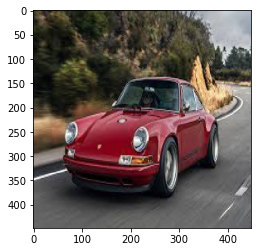

In [5]:
test_image = 'my_testset/car1.jpg'
processed_img = preprocess(test_image)
print(processed_img.shape)
img_t = np.transpose(processed_img, (1,2,0))
print(img_t.shape)
plt.imshow(img_t)

In [6]:
conv_layers[0].__dict__

{'_built': True,
 '_constraints': {},
 '_initial_weights': None,
 '_losses': [],
 '_non_trainable_weights': [],
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_trainable_weights': [<tf.Variable 'conv1/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
  <tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32_ref>],
 '_updates': [],
 'activation': <keras.layers.advanced_activations.LeakyReLU at 0x2dffba08d30>,
 'activity_regularizer': None,
 'batch_input_shape': (None, 3, 448, 448),
 'bias': <tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32_ref>,
 'bias_constraint': None,
 'bias_initializer': <keras.initializers.Zeros at 0x2dffba08da0>,
 'bias_regularizer': None,
 'data_format': 'channels_first',
 'dilation_rate': (1, 1),
 'dtype': 'float32',
 'filters': 16,
 'inbound_nodes': [<keras.engine.topology.Node at 0x2dffba08f28>],
 'input_spec': <keras.engine.topology.InputSpec at 0x2dff4dbc940>,
 'kernel': <tf.Variable 'conv1/kernel:0' shape=(3, 3, 3, 16) dtype=float32_ref>,
 'kernel

In [12]:
for each_layer in model.layers:
    print(each_layer.name)

conv1
max_pooling2d_1
conv2
max_pooling2d_2
conv3
max_pooling2d_3
conv4
max_pooling2d_4
conv5
max_pooling2d_5
conv6
max_pooling2d_6
conv7
conv8
conv9
flatten_1
new_dense1
new_dense2
new_detection


In [7]:
model.layers[0].output

<tf.Tensor 'conv1/leaky_re_lu_1/sub:0' shape=(?, 16, 448, 448) dtype=float32>

In [17]:
def deprocess_image(img):
    """Utility function to convert optimized image output into a valid image.
    Args:
        img: N dim numpy image array with shape: `(channels, image_dims...)` if data_format='channels_first' or
            `(image_dims..., channels)` if data_format='channels_last'.
    Returns:
        A valid image output.
    """
    # normalize tensor: center on 0., ensure std is 0.1
    img = img.copy()
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # convert to RGB array
    img *= 255
    return np.clip(img, 0, 255).astype('uint8')

In [25]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {inp_x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)
    
    print("values.shape", values.shape)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[1]
    
    print("num_filters", num_filters)

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    print("num_grids", num_grids)
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids, figsize=(10,10))

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, i, :, :]
            # img = deprocess_image(img)
            # Plot image.
            ax.imshow(img)
            # ax.imshow(img, interpolation='nearest', cmap='binary')
            # ax.imshow(img, interpolation='bicubic', cmap='Greys')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

values.shape (1, 16, 448, 448)
num_filters 16
num_grids 4


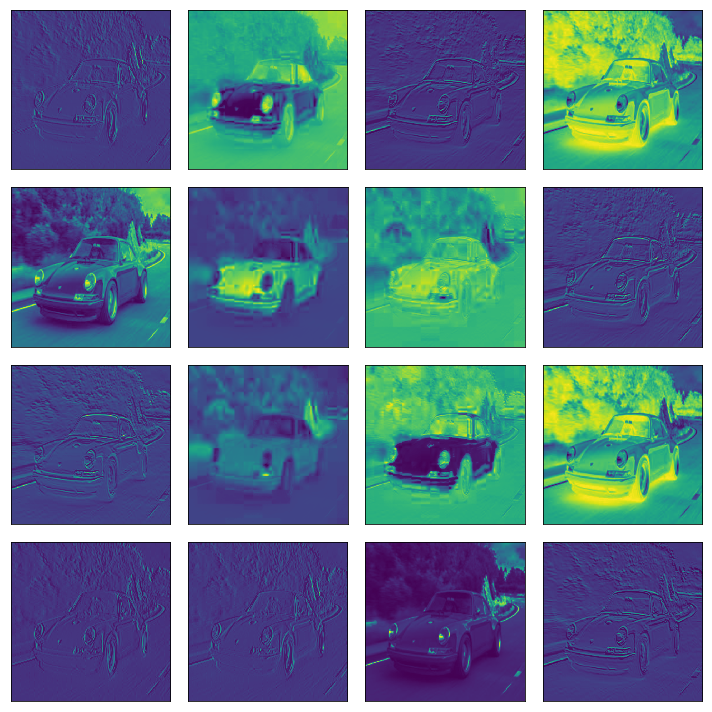

In [26]:
plot_conv_layer(model.layers[0].output, processed_img)

values.shape (1, 16, 224, 224)
num_filters 16
num_grids 4


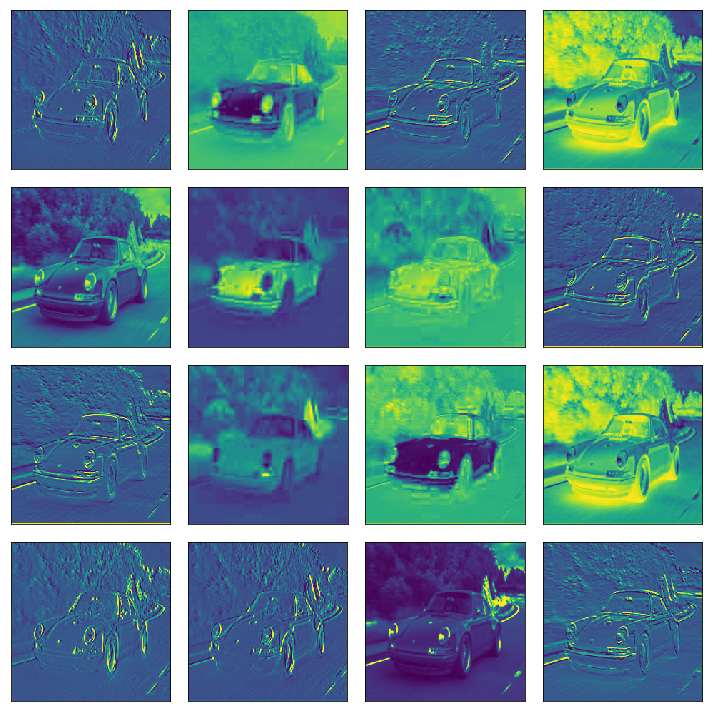

In [22]:
plot_conv_layer(model.layers[1].output, processed_img)

values.shape (1, 32, 224, 224)
num_filters 32
num_grids 6


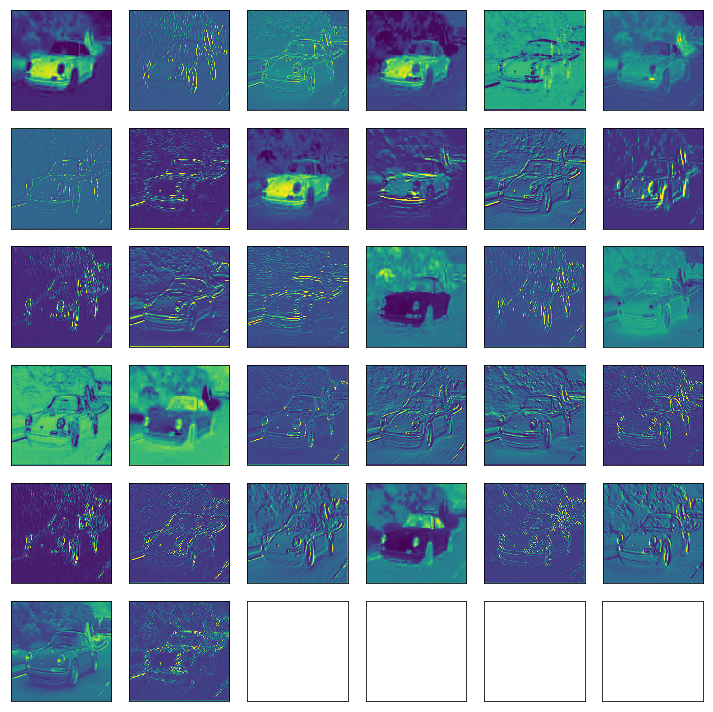

In [23]:
plot_conv_layer(model.layers[2].output, processed_img)

values.shape (1, 64, 112, 112)
num_filters 64
num_grids 8


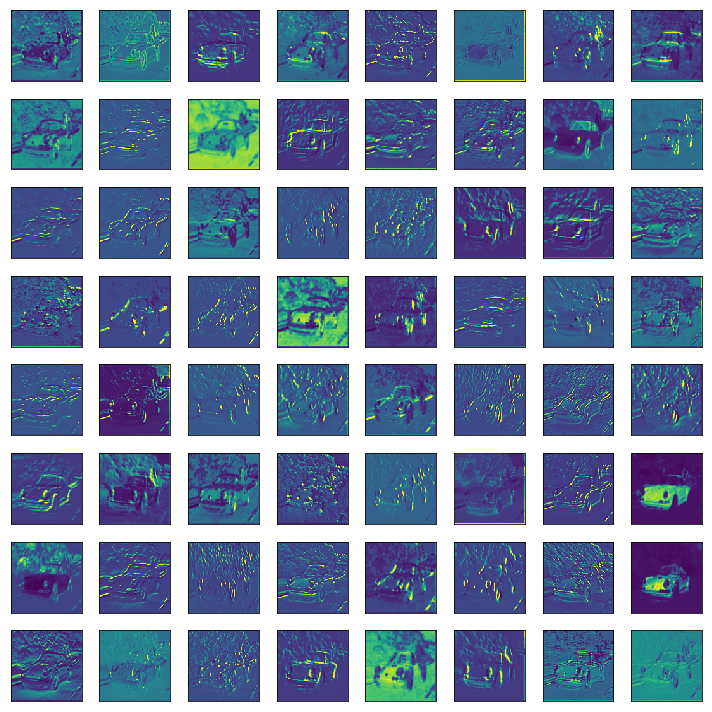

In [24]:
plot_conv_layer(model.layers[4].output, processed_img)